In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


In [4]:
train_dir = os.path.join('tumor',  'Training')
test_dir = os.path.join('tumor', 'Testing')

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

# # Print paths to verify
print("Training Directory:", train_dir)
print("Testing Directory:", test_dir)
print("Categories:", categories)




Training Directory: tumor\Training
Testing Directory: tumor\Testing
Categories: ['glioma', 'meningioma', 'notumor', 'pituitary']


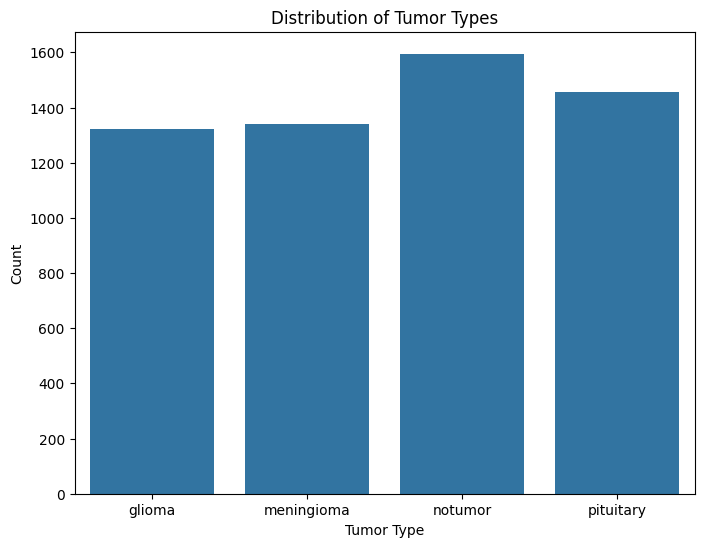

In [5]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()


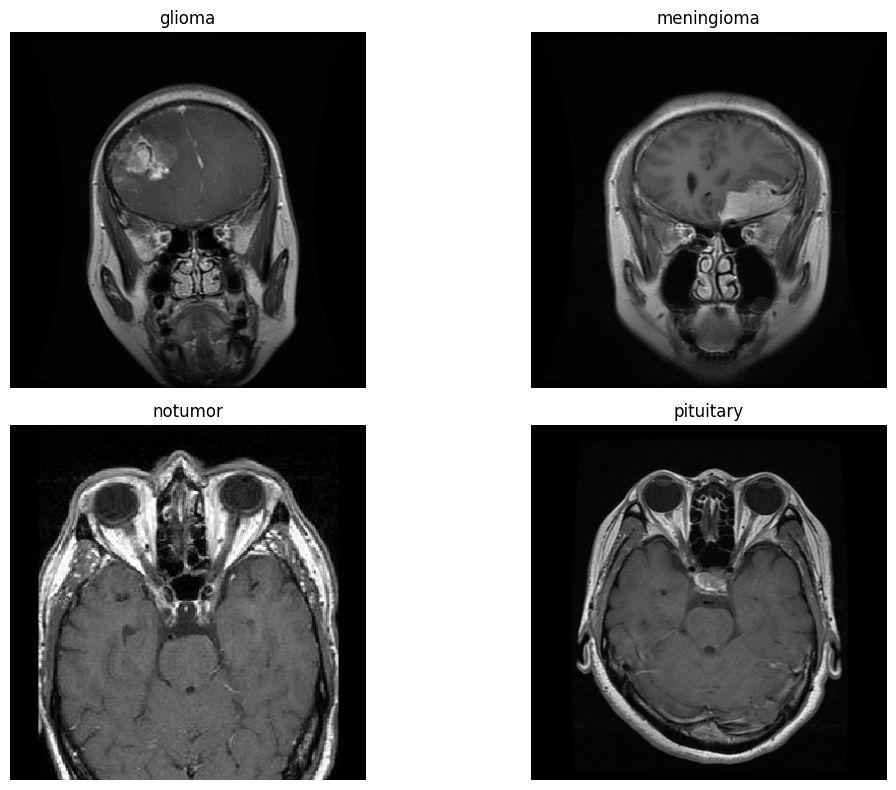

In [6]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [7]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [8]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [9]:
# Define the model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(image_size[0], image_size[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation="relu"),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation="relu"),
    Dropout(0.5),
    Dense(len(categories), activation="softmax")
])

# Compile the model
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [10]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50
178/178 [==============================] - 775s 4s/step - loss: 0.9802 - accuracy: 0.5662 - val_loss: 1.3421 - val_accuracy: 0.4953
Epoch 2/50
178/178 [==============================] - 493s 3s/step - loss: 0.7404 - accuracy: 0.7025 - val_loss: 0.8164 - val_accuracy: 0.6727
Epoch 3/50
178/178 [==============================] - 462s 3s/step - loss: 0.6350 - accuracy: 0.7489 - val_loss: 1.3428 - val_accuracy: 0.5070
Epoch 4/50
178/178 [==============================] - 323s 2s/step - loss: 0.5541 - accuracy: 0.7827 - val_loss: 1.1442 - val_accuracy: 0.6367
Epoch 5/50
178/178 [==============================] - 239s 1s/step - loss: 0.4802 - accuracy: 0.8153 - val_loss: 0.8107 - val_accuracy: 0.7094
Epoch 6/50
178/178 [==============================] - 241s 1s/step - loss: 0.4607 - accuracy: 0.8238 - val_loss: 0.6212 - val_accuracy: 0.7305
Epoch 7/50
178/178 [==============================] - 243s 1s/step - loss: 0.4064 - accuracy: 0.8467 - val_loss: 0.5280 - val_accuracy: 0.7969

In [4]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

NameError: name 'history' is not defined

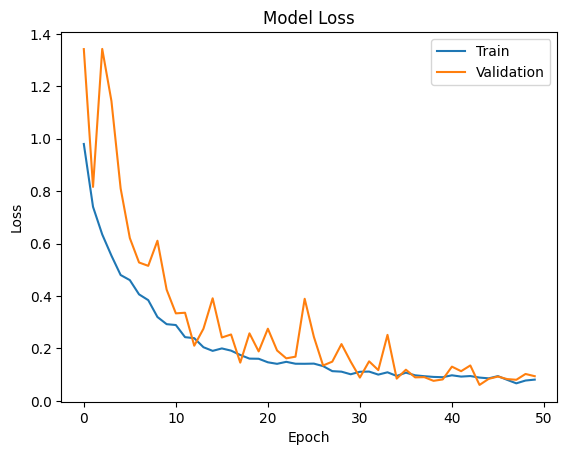

In [12]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [13]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 12s 301ms/step - loss: 0.0941 - accuracy: 0.9609
Test Loss: 0.09412773698568344
Test Accuracy: 0.9609375


41/41 [==============================] - 16s 296ms/step


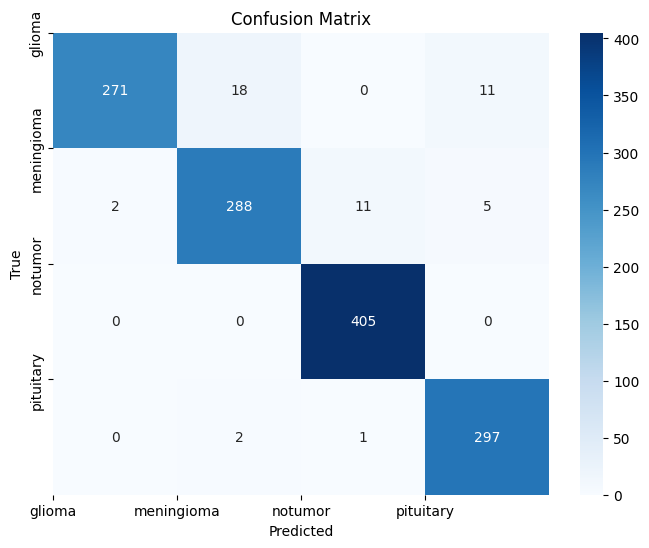

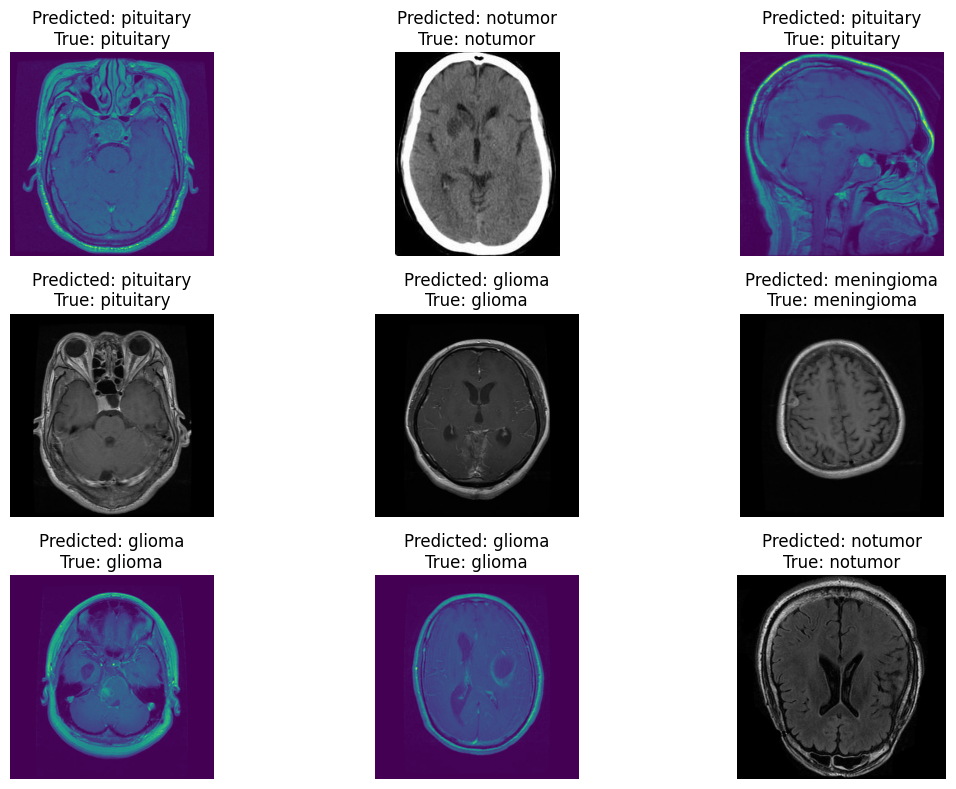

In [14]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


In [3]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

NameError: name 'confusion_matrix' is not defined

In [18]:
# Save the trained model
model.save("brains.h5")


In [3]:
from tensorflow.keras.preprocessing import image
from keras.models import load_model
import numpy as np
model=load_model("brains.keras")
img_path = "tumor/Testing/glioma/Te-gl_0010.jpg"
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(150, 150))  # Resizing to the model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image data
    return img_array

def predict_image(img_path):
    # Preprocess the image
    preprocessed_img = preprocess_image(img_path)

    # Run the prediction
    prediction = model.predict(preprocessed_img)

    # Get the class index with the highest probability and its confidence score
    predicted_class = np.argmax(prediction, axis=1)[0]
    categories = ["glioma", "meningioma", "notumor", "pituitary"]
    predicted_category = categories[predicted_class]
    confidence_score = np.max(prediction) * 100  # Convert to percentage

    # Print the result
    print(f'Predicted class: {predicted_category}, Confidence: {confidence_score:.2f}%')
predict_image(img_path)

1/1 [==============================] - 1s 537ms/step
Predicted class: glioma, Confidence: 99.56%
